# Load Python libraries

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics, ensemble
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Data Preparation

In [2]:
# 5% of Data is used in the kernel.
# Merge songs & members into train datasets

# Load data
df = pd.read_csv('train.csv')

# 5% sample of items
df = df.sample(frac=0.05)

# Load and join songs data
songs = pd.read_csv('songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')

# Load and join songs data
members = pd.read_csv('members.csv')
df = pd.merge(df, members, on='msno', how='left')

In [3]:
del songs
del members

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368871 entries, 0 to 368870
Data columns (total 18 columns):
msno                      368871 non-null object
song_id                   368871 non-null object
source_system_tab         367604 non-null object
source_screen_name        348043 non-null object
source_type               367797 non-null object
target                    368871 non-null int64
song_length               368866 non-null float64
genre_ids                 362942 non-null object
artist_name               368866 non-null object
composer                  285011 non-null object
lyricist                  210059 non-null object
language                  368862 non-null float64
city                      368871 non-null int64
bd                        368871 non-null int64
gender                    221567 non-null object
registered_via            368871 non-null int64
registration_init_time    368871 non-null int64
expiration_date           368871 non-null int64
dtypes: flo

In [5]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.343481
source_screen_name         5.646418
source_type                0.291159
target                     0.000000
song_length                0.001355
genre_ids                  1.607337
artist_name                0.001355
composer                  22.734235
lyricist                  43.053534
language                   0.002440
city                       0.000000
bd                         0.000000
gender                    39.933744
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [6]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:
# Create 6 columns (days, months, years of registration_init_time and expiration_date respectively)

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,3VBkA5QPjg9yrXN/c9Q4ILVNAkY30PmSuEzZMgNEDiU=,Nbxpa0iu1ZDI345SxmkckzCLvHXxVqI4M305UtJCsc8=,discover,Online playlist more,online-playlist,0,205821.0,1259,Drake| Future,Nayvadius Wilburn| Leland Wayne| Aubrey Graham,...,female,3,2012-09-30,2017-09-06,2012,9,30,2017,9,6
1,RYH4fwRVZpXmknt4nlHbJpRRn0FDED7iAL4dvi9kLuE=,E/fGADsEvdUw1YhiHRSxYlEgs8rZEEGxo+fTqZRE2Ss=,discover,Discover Feature,online-playlist,1,247144.0,465,IU,IU,...,unknown,7,2012-12-14,2017-09-19,2012,12,14,2017,9,19
2,TFk9LMzIPBiL1Q5UageyKeerqKVC+AYcSFzS7fO2Xio=,44m6SiVbMCsAgkpYwRq/w4pzXaWimDSrSNkcz66f0AQ=,my library,Local playlist more,local-library,1,205264.0,1609,Far East Movement,unknown,...,male,9,2011-08-09,2018-05-10,2011,8,9,2018,5,10
3,gTnIinEU3SoUXNoTKiVFNWXroXALhnsG7hA+0+I4xlg=,6I5T/8wa+FPTSpa8NFnVSpeHusjUBfBBb+L6jlt4ugE=,my library,Local playlist more,local-library,0,129750.0,921,Various Artists,unknown,...,female,9,2015-03-06,2017-11-28,2015,3,6,2017,11,28
4,9i5svqiBA42tojUF+HhN8n6tCk94SeYt/Y37RNqlRak=,b3tUwLJuxVKVeMduaM8ZNl1hPiqkAtu3jQqdhEYydvI=,radio,Radio,radio,0,189474.0,921|726,Pixar Greatest,Randy Newman,...,unknown,7,2015-07-11,2017-07-10,2015,7,11,2017,7,10


In [9]:
# Dates to category
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [10]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

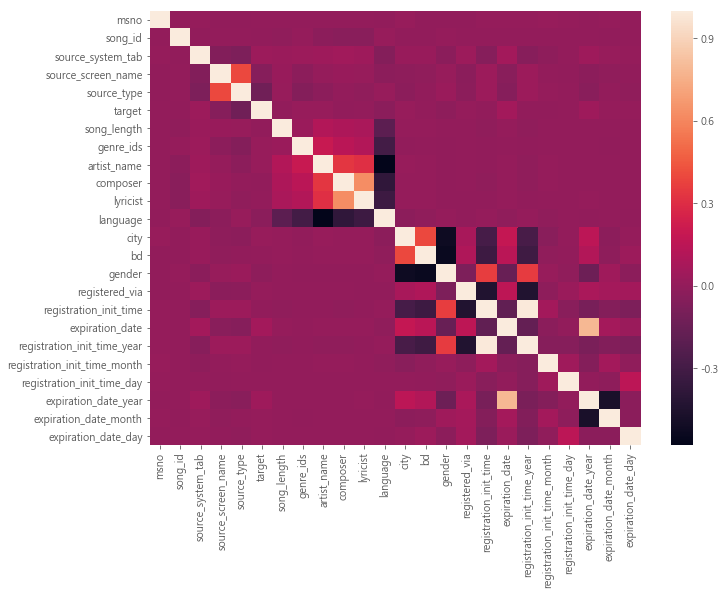

In [11]:
# Сorrelation matrix
plt.figure(figsize=[11,8])
sns.heatmap(df.corr())
plt.show()

In [12]:
# Drop correlated columns
# 'expiration_date' is correlated with 'expirationdate_year' very strongly.
# 'lyricist' is correlated with 'composer'.
df = df.drop(['expiration_date', 'lyricist'], 1)

# Random Forest for feature selection

In [13]:
# Model with the best estimator (to select the most informative columns using Random Forest Model)
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

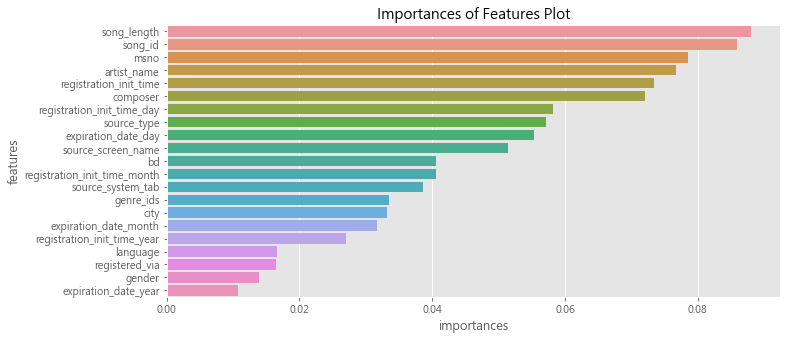

In [15]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [16]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [17]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
       'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

# XGboost for model training

In [18]:
# Train & Test split
target = df.pop('target')
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [19]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
# Predicting
predict_labels = model.predict(test_data)

# Model Evaluation

In [21]:
# Accuracy analysis
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64     55091
           1       0.65      0.68      0.66     55571

    accuracy                           0.65    110662
   macro avg       0.65      0.65      0.65    110662
weighted avg       0.65      0.65      0.65    110662



Confusion matrix, without normalization
[[34654 20437]
 [17879 37692]]
Normalized confusion matrix
[[0.63 0.37]
 [0.32 0.68]]


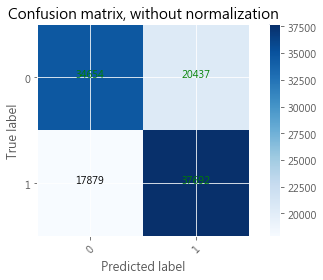

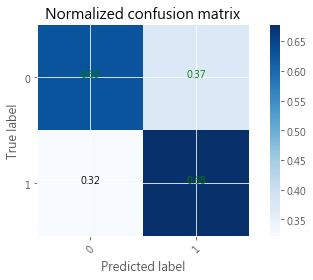

In [22]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="green" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predict_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [23]:
# Predict probability for ROC curve
predict_labels = model.predict_proba(test_data)

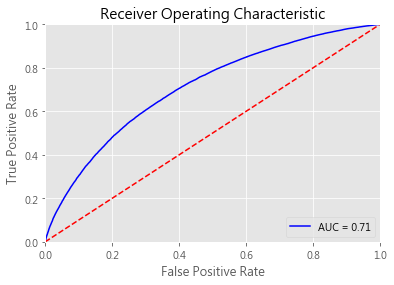

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    test_labels, [i[1] for i in predict_labels])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()